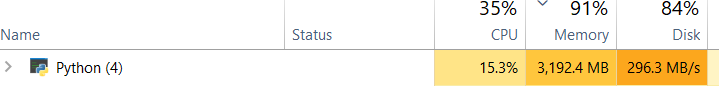

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy as sp

import sqlite3
import os
from pandas import read_sql


from sklearn.neighbors import kneighbors_graph as knn
from sklearn.preprocessing import RobustScaler
import spektral 
from spektral.data import Dataset, Graph

from tqdm.notebook import tqdm


#### Put on GPU when possible
put_on_gpu = False

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0 and put_on_gpu:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [18]:
class ParticleDataset(Dataset):
    def __init__(self,data = []):
        self.data = np.array(data)
        
    def read(self):
        return self.data
    
    def generate_data(self, path = None,limit = 1e3, pid = 13,cleaning = 1):
        n_neighbors = 5
        
        if not path:
            path = "C:/Users/jakob/Documents/Bachelorproject - IceCube ML/data/rasmus_classification_muon_3neutrino_3mio.db"
        
        with sqlite3.connect(path) as con:
            query = f'select * from truth where pid = {pid} LIMIT {limit}'
            truth = pd.read_sql(query, con)
            
            # Make sure the same events are used:
            events = tuple(truth["event_no"])
            
            query = f'select * from features where event_no in {events} and SRTInIcePulses = {cleaning}'
            features = pd.read_sql(query, con)


        print(features.columns)
        print(truth.columns)
        print(len(features),len(truth))
        featurelist = ["dom_x","dom_y","dom_z","time","charge_log10"]
        pos = ["dom_x","dom_y","dom_z"]
        target_features = ['energy_log10','azimuth','zenith']
#         target_features = ["energy_log10"]
        
        features_arr = np.array(features[featurelist])
        truth_arr = np.array(truth[target_features])

        graphs = []
        targets = []

        #Find when event type changes
        _, changes = np.unique(features["event_no"].values,return_index = True)
        changes = np.append(changes,len(features))
        
        for i in tqdm(range(len(changes)-1)):
            ind0,ind1 = changes[i],changes[i+1]
            seq = features[ind0:ind1]
            target = truth_arr[i]
            try:
                nbs = knn(seq[pos],n_neighbors)
            except:
                nbs = sp.sparse.eye(n_neighbors)
#             dists = knn(seq[pos],n_neighbors,mode = "distance")
            if len(target) == 0:
              continue
            # print((target.values))
            # print((seq[features]))
            x = features_arr[ind0:ind1]
            graph = Graph(x = x, a = nbs.T, y = target)
            
            graphs.append(graph)
            targets.append(target)
        self.data = np.array(graphs,dtype=object)

dataset = ParticleDataset()
dataset.generate_data(limit = 2*1e5)

Index(['row', 'event_no', 'string', 'dom', 'pmt', 'dom_x', 'dom_y', 'dom_z',
       'pmt_x', 'pmt_y', 'pmt_z', 'pmt_area', 'pmt_type', 'time',
       'charge_log10', 'lc', 'pulse_width', 'SplitInIcePulses',
       'SRTInIcePulses'],
      dtype='object')
Index(['event_no', 'energy_log10', 'time', 'position_x', 'position_y',
       'position_z', 'direction_x', 'direction_y', 'direction_z', 'azimuth',
       'zenith', 'pid', 'interaction_type', 'muon_track_length',
       'stopped_muon'],
      dtype='object')
6151995 200000


  0%|          | 0/200000 [00:00<?, ?it/s]

In [3]:
len(dataset.data)

100000

In [19]:
lim_per_file = int(5*1e6)
for i in range(1):
#   try:
    p = "2e5generatedDataAnglesEnergyClean"+str(len(dataset.data))+" "+str(i)
    np.savez(p,dataset.data[i*lim_per_file:(i+1)*lim_per_file])
    #   except:
    print("File created")

File created


In [20]:
dataset.read()

array([Graph(n_nodes=13, n_node_features=5, n_edge_features=None, n_labels=3),
       Graph(n_nodes=28, n_node_features=5, n_edge_features=None, n_labels=3),
       Graph(n_nodes=281, n_node_features=5, n_edge_features=None, n_labels=3),
       ...,
       Graph(n_nodes=29, n_node_features=5, n_edge_features=None, n_labels=3),
       Graph(n_nodes=12, n_node_features=5, n_edge_features=None, n_labels=3),
       Graph(n_nodes=11, n_node_features=5, n_edge_features=None, n_labels=3)],
      dtype=object)